# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def show_distinct_column_values(df, columns_list):
    '''
    Show distinct values for each column in the list.
    
    Input:
        df: data frame to process
        column_list: list of columns to analyze
    
    '''
    for column in columns_list:
        print(column)
        values_list = df[column].unique() 
    
        print(values_list)

In [3]:
def show_mixed_values(df, column_list):
    '''
    Show all columns and their values, if a column contains mixed data types.
    
    Input:
        df: data frame to process
        column_list: list of columns to analyze
    '''
    for column_name in column_list:
        values_list = df[column_name].unique() 
    
    print("{}, values: {}.".format(column_name, values_list))

In [4]:
def clean_individual_columns(df):
    '''
    Clean individual columns of a data frame.
    
    Input:
        - df: data frame to be cleaned
    '''
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace = True)
    df['OST_WEST_KZ'] = pd.to_numeric(df['OST_WEST_KZ'])
    df['GEBURTSJAHR'].replace(0, np.nan, inplace = True)
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace = True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace = True)
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'],errors = 'coerce')
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'],errors = 'coerce')

In [5]:
def convert_unknown_to_nan(df, unknown_values_dict):
    """
    Convert string values like "unknown" to "NaN" for all columns 
    in the data frame that can be found in the dictionary.
    
    Input:
        df: a data frame to be converted
        unknown_values_dict: a map with columns names and values to be converted to NaN
        
    Output:
        A converted data frame.
    """
    for attribute in unknown_values_dict:
        if attribute in df.columns:
            values_list = unknown_values_dict[attribute]
            
            for value in values_list:
                df[attribute] = df[attribute].apply(lambda x: np.nan if x == int(value) else x)
    return df

In [6]:
def prepare_categorical_to_process(df, drop_list, nominal_list):
    '''
    Produce lists of object, nominal and binary columns for the provided data frame.
    
    Input:
        df: data frame to process
        drop_list: list of columns to drop for the same data frame
        nominal_list: list of nominal columns from the same data frame
        
    Output:
        nominal_to_process: list of nominal columns reduced by columns to drop
        binary_to_process: list of binary columns reduced by columns to drop
        object_to_process: list of object columns reduced by columns to drop
    '''
    nominal_to_process = list(set(nominal_list) - set(drop_list))
    
    binary_columns = list(df.loc[:, df.nunique() == 2].columns)
    binary_to_process = list(set(binary_columns) - set(drop_list))
    
    object_columns = list(df.select_dtypes(['object']).columns)
    object_to_process = list(set(object_columns) - set(drop_list))
    
    return nominal_to_process, binary_to_process, object_to_process

In [7]:
def prepare_numerical_to_process(df, categorical_list):
    '''
    Produce a list of numerical columns from the provided data frame.
    
    Input:
        df: data frame to process
        categorical_list: list of categorical columns from the same data frame
        
    Output:
        numerical_to_process: list of numerical columns reduced by categorical columns
    '''
    numerical_to_process = list(set(df.columns) - set(categorical_list))
    
    return numerical_to_process

In [8]:
def replace_xx_with_nan(df):
    '''
    Replace values like 'X' and 'XX' witn NaNs for all object type columns of the data frame.
    
    Input:
        df: data frame to process
    '''
    column_list = list(df.select_dtypes('object').isin(['X', 'XX']).any().loc[lambda x: x == True].index)
    for column in column_list:
        df[column] = df[column].apply(lambda x: np.nan if x in ('X','XX') else x)

In [9]:
def impute_missing_values(df, categorical_list, numerical_list):
    '''
    Impute missing values of categorical and numerical columns for a given data frame.
    
    Input:
        df: data frame to process
        categorical_list: list of categorical columns of a given data frame
        numerical_list: list of numerical columns of a given data frame
    '''
    df[categorical_list] = df[categorical_list].fillna(df.mode().iloc[0])
    df[numerical_list] = df[numerical_list].fillna(df.median().iloc[0])

In [10]:
def report_skewness (df, column_list, dataset_name):
    '''
    Analyze and report skewness of a given column list and data frame.
    
    Input:
        df: data frame to process
        column_list: list of columns to be analyzed for skewness
        dataset_name: a name of a data set to be used as a label for a report.
    '''
    df_skew = df[column_list].skew(axis = 0)
    num_of_skewed_cols = df_skew[abs(df_skew) > 0.5].count()
    min_skew = round(df_skew.min(), 2)
    max_skew = round(df_skew.max() , 2)
    
    print("The dataset {} has min skew of {} and max skew of {}.".format(dataset_name, min_skew, max_skew))
    print("The dataset {} has {} columns with abs(skew) greater than 0.5.".format(dataset_name, num_of_skewed_cols))

In [11]:
def plot_component_weights_and_features(component_number, pca_model, df):
    '''
    Produce a bar plot to show distribution of component weights and their features.
    
    Input:
        component_number: a single component to be analyzed
        pca_model: a PCA model whose component will be analyzed
        df: a data frame to process
        
    Output:
        wf_data: a data frame with weights and features to be used as a basis for a bar plot
    '''
    component = pca_model.components_[component_number]
    wf = pd.DataFrame(list(zip(component, df.columns)), columns=['Weights', 'Features'])
    wf['abs_weights'] = wf['Weights'].apply(lambda x: np.abs(x))
    wf_data = wf.sort_values('abs_weights', ascending = False).head(10)
    ax = sns.barplot(data = wf_data, x = 'Weights', y = 'Features', palette = 'rocket')
    
    ax.set_title('PCA Component number: ' + str(component_number))
    plt.show()
    
    return wf_data

In [12]:
def find_rows_to_drop(df, percent):
    '''
    Find rows based on criteria and mark them for drop.
    
    Input:
        df: data frame to process
        percent: a percent of missing values in the row determining whether row should be dropped
        
    Output: a lisy of row number which are to be dropped    
    '''
    no_of_nan = df.isnull().sum(axis=1)
    perc_of_nan = (no_of_nan / len(df.columns)) * 100
    to_drop = perc_of_nan[(perc_of_nan.values > percent )].index
    
    return to_drop

In [13]:
def perform_pca(df, components_number):
    '''
    Build a PCA model for a given data set and a number of components.
    
    Input:
        df: data set to process
        component_number: number of components to model
        
    Output:
        pca_model: a PCA model
        transformed_df: a transformed dataset
    '''
    pca_model = PCA(components_number)
    transformed_df = pca_model.fit_transform(df)
    
    return pca_model, transformed_df

In [14]:
def log_transform_skewed_columns(df, column_list):
    '''
    Perform log transform on the list of skewed columns for a given list and a data frame.
    
    Input:
        df: data frame to process
        column_list: a list of columns to be log transformed
        
    Output: a new data frame with log transformed columns
    '''
    transformed_df = np.log1p(df[column_list])
    
    return transformed_df

In [15]:
def log_transform_skewed_data_frame(df):
    '''
    Perform log transform on the given data frame.
    
    Input:
        df: data frame to process
        
    Output: a new data frame with log transformed columns
    '''
    transformed_df = np.log1p(df)
    
    return transformed_df

In [220]:
def plot_cluster_details(cluster_number, pca_model, kmeans_model, df, attribute_details):
    '''
    Produce a bar plot to show cluster features and their values for a given cluster
    
    Input:
        cluster_number: a single cluster to be analyzed
        pca_model: a PCA model which will be analyzed
        kmeans_model: kmeans model to be abalyzed
        df: a data frame to process
        attribute_details: data frame with attribute details such as description, meaning etc.
        
    Output:
        cluster_data: a data frame with features which contribute to cluster the most
    '''
    
    cluster_values = pca_model.inverse_transform(kmeans_model.cluster_centers_[cluster_number])
    cluster_df = pd.DataFrame(list(zip(cluster_values, df.columns)), columns=['Values', 'Features'])
    
    cluster_head = cluster_df.sort_values('Values', ascending = False).head(5)
    cluster_data = cluster_head.append(cluster_df.sort_values('Values', ascending = False).tail(5))
    
    desc = []

    for feature in cluster_data.Features:
        if feature in attribute_details.Attribute.values:
            desc.append(attribute_values[attribute_details.Attribute == feature].Description.values[0])
        else:
            desc.append('Description missing')

    description_df = pd.DataFrame({'Descriptions':desc})
    cluster_data['Descriptions'] = description_df.Descriptions.values

    ax = sns.barplot(data = cluster_data, x = 'Values', y = 'Features', palette = 'flare')
    ax.set_title('Cluster number: ' + str(cluster_number))
    plt.show()
    
    return cluster_data

In [210]:
def clean_mailout_data(df, unknown_values, drop_list, hidden_list):
    '''
    Clean mailout data set by removing incorrect data and dropping columns.
    
    Input:
        df: data frame to process
        unknow_values: the list of values that are aliases for missing values
        drop_list: the list of column names to drop
        hidden_list: the list of "hidden" columns with a. lot of missing data
        
    Output: a new data frame with cleaned data
    '''
    replace_xx_with_nan(df)
    clean_individual_columns(df)
    df_conv = convert_unknown_to_nan(df, unknown_values)
    
    df_reduced = df_conv.drop(columns = drop_list, axis = 1)
    df_reduced = df_reduced.drop(columns = hidden_list, axis = 1)
    
    return df_reduced

In [211]:
def impute_mailout_data(df, drop_list, nominal_list):
    '''
    Perform data imputation on the given data frame.
    
    Input:
        df: data frame to process
        drop_list: list of columns to drop
        nominal_list: list of nominal columns
        
    Output: a new data frame imputed data and list of categorical columns
    '''
    temp_df = df
    mail_nominal, mail_binary, mail_object = prepare_categorical_to_process(temp_df, 
                                                                            drop_list,
                                                                            nominal_list)

    mail_categorical = mail_nominal + mail_binary + mail_object
    mail_categorical = list(dict.fromkeys(mail_categorical))
    mail_numerical = prepare_numerical_to_process(temp_df, mail_categorical)
    
    impute_missing_values(temp_df, mail_categorical, mail_numerical)
    
    return temp_df, mail_categorical

In [212]:
def encode_and_scale_mailout_data(df, categorical_list):
    '''
    Perform encoding and scaling on the given data frame.
    
    Input:
        df: data frame to process
        categorical_list: list of categorical columns in the data frame
        
    Output: a new data frame with encoded and scaled data
    '''
    encoded_df = pd.get_dummies(df, drop_first = True, columns = categorical_list)
    log_transformed_df = log_transform_skewed_data_frame(encoded_df)
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_transformed_df)
    scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns)
    
    return scaled_df

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [16]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/vajolukic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# load pickled data
#azdias = pd.read_pickle('azdias.pickle')
#customers = pd.read_pickle('customers.pickle')

## Exploring the data

### Head and shape of the data sets

In [18]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [19]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Some columns have a lot of missing values in both datasets. To explore that further, we need to study the description of attributes in the file 'DIAS Attributes - Values 2017.xlsx'.

In [20]:
print(azdias.shape)

(891221, 366)


Azdias (general population) dataset has 891221 observations and 366 features.

In [21]:
print(customers.shape)

(191652, 369)


Customers dataset has 191652 observations and 369 features, 3 features more than in Azdias datset.

In [22]:
customers_columns_difference = list(azdias.columns.symmetric_difference(customers.columns))
print("The columns that exist in Customers dataset which cannot be found in Azdias dataset: {}"
      .format(customers_columns_difference))

The columns that exist in Customers dataset which cannot be found in Azdias dataset: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


### Statistics of the data sets

In [23]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [24]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


By looking at the mean and standard deviation values it's telling us that we will have to center the data before processing it further.

### Types of data in the datasets

Quick analysis shows quite different distributions of data in features. That is worth exploring more to see what data types are represented and how much in each dataset.

In [25]:
print(azdias.dtypes.value_counts())

float64    267
int64       93
object       6
dtype: int64


There are 6 columns of a type object, 93 integer and 267 decimal columns with decimal data in Azdias data set.

In [26]:
print(customers.dtypes.value_counts())

float64    267
int64       94
object       8
dtype: int64


And there are 8 columns of a type object, 94 integer and 267 decimal columns with decimal data in Customers data set.

### Addressing warnings

We have received some warnings while loading data files. Apparently few columns have mixed data types. 
We have to investigate this and probably clean that data afterwards.

In [27]:
azdias_mixed_type_columns = list(azdias.columns[18:20])

We'll save these columns for later to do some cleaning. Let's observe their values first.

In [28]:
show_mixed_values(azdias, azdias_mixed_type_columns)

CAMEO_INTL_2015, values: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX'].


These two columns are of the type "object" and they have mixed decimal values and string values 'X' and 'XX'.
Let's check now if there are any other columns that contain such string values.

In [29]:
columns_with_XX = list(azdias.select_dtypes('object').isin(['X', 'XX']).any().loc[lambda x: x == True].index)
print(columns_with_XX)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


There is one more column like that, 'CAMEO_DEU_2015'. Let's see its values.

In [30]:
show_mixed_values(azdias, columns_with_XX)

CAMEO_INTL_2015, values: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX'].


This column also has 'XX' values which we need to replace with null values.

### Analyzing object columns

The "object" type of columns might be ineteresting to explore a bit more to see their distinct values.

In [31]:
object_type_columns = list(azdias.select_dtypes(['object']).columns)
print(object_type_columns)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']


In [32]:
show_distinct_column_values(azdias, object_type_columns)

CAMEO_DEU_2015
[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']
D19_LETZTER_KAUF_BRANCHE
[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REI

- CAMEO_DEU_2015: has an undefined value 'XX'. This will have to be replaced with null value.
- CAMEO_DEUG_2015: has an undefined value 'X'. This will have to be replaced with null value.
- CAMEO_INTL_2015: has an undefined value 'XX'. This will have to be replaced with null value.
- EINGEFUEGT_AM: this field has not been described in the additional document. If we translate it from German, 
  it says it means "Inserting time". this information is not relevant so this field will be dropped later.
- OST_WEST_KZ: has two distinct string vaues which we have to convert to numerical values.
- CAMEO_DEUG_2015 and CAMEO_INTL_2015 will have to be converted to float type.

### Analyzing integer columns

In [33]:
int64_type_columns = list(azdias.select_dtypes(['int64']).columns)
print(int64_type_columns)

['LNR', 'AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_D

In [34]:
show_distinct_column_values(azdias, int64_type_columns)

LNR
[910215 910220 910225 ... 825772 825776 825787]
AGER_TYP
[-1  2  3  0  1]
D19_BANKEN_ANZ_12
[0 3 1 2 4 5 6]
D19_BANKEN_ANZ_24
[0 5 1 2 4 3 6]
D19_BANKEN_DATUM
[10  5  8  6  9  1  7  4  2  3]
D19_BANKEN_DIREKT
[0 1 6 5 4 3 7 2]
D19_BANKEN_GROSS
[0 2 6 3 5 1 4]
D19_BANKEN_LOKAL
[0 7 3 6 5 2 1 4]
D19_BANKEN_OFFLINE_DATUM
[10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM
[10  5  8  6  9  1  4  7  2  3]
D19_BANKEN_REST
[0 6 5 4 3 7 2 1]
D19_BEKLEIDUNG_GEH
[0 6 5 7 3 2 4 1]
D19_BEKLEIDUNG_REST
[0 1 6 7 5 3 4 2]
D19_BILDUNG
[0 6 3 7 2 4 5 1]
D19_BIO_OEKO
[0 6 7 3 5 2 4 1]
D19_BUCH_CD
[0 6 5 3 1 7 4 2]
D19_DIGIT_SERV
[0 6 7 3 5 2 4 1]
D19_DROGERIEARTIKEL
[0 1 6 3 7 4 5 2]
D19_ENERGIE
[0 5 3 6 7 2 1 4]
D19_FREIZEIT
[0 7 3 6 5 4 1 2]
D19_GARTEN
[0 3 6 7 5 4 2 1]
D19_GESAMT_ANZ_12
[0 6 1 2 3 4 5]
D19_GESAMT_ANZ_24
[0 6 1 2 3 5 4]
D19_GESAMT_DATUM
[10  1  3  5  9  4  7  6  8  2]
D19_GESAMT_OFFLINE_DATUM
[10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM
[10  1  3  5  9  4  7  6  8  

- LNR: this field seems to be an id of the record. It is not relevant for analysis so it will be dropped later.
- GEBURTSJAHR: has value "0" which has to be replaced with null value. This is also a real integer column.
- Most of other ineteger columns have a very narrow range of distinct values. This indicates that they actually might represent categorical values although they have numerical values
- VERS_TYP and ANREDE_KZ are columns with binary values (1 and 2) which have to be converted to 0 and 1.

### Analyzing decimal columns

In [35]:
float64_type_columns = list(azdias.select_dtypes(['float64']).columns)
print(float64_type_columns)

['AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEZOGENAM_HH_JAHR', 'EWDICHTE', 'EXTSEL992', 'FIRMENDICHTE', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEMEINDETYP', 'GFK_URLAUBERTYP', 'HH_DELTA_FLAG', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL

In [36]:
show_distinct_column_values(azdias, float64_type_columns)

AKT_DAT_KL
[nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]
ALTER_HH
[nan  0. 17. 13. 20. 10. 14. 16. 21. 11. 19. 15.  9. 18.  8.  7. 12.  4.
  3.  6.  5.  2.  1.]
ALTER_KIND1
[nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]
ALTER_KIND2
[nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]
ALTER_KIND3
[nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]
ALTER_KIND4
[nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]
ALTERSKATEGORIE_FEIN
[nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]
ANZ_HAUSHALTE_AKTIV
[ nan  11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.
   7.  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.
  18.  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.
  38.  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.
  43.  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.
  78.  70.  46. 185.

[nan  3.  4.  0.  2.  5.  1.]
KBA13_BJ_2009
[nan  2.  1.  3.  5.  0.  4.]
KBA13_BMW
[nan  3.  4.  2.  5.  1.]
KBA13_CCM_0_1400
[nan  2.  1.  3.  5.  0.  4.]
KBA13_CCM_1000
[nan  0.  1.  4.  5.  3.  2.]
KBA13_CCM_1200
[nan  0.  2.  1.  4.  5.  3.]
KBA13_CCM_1400
[nan  4.  2.  3.  1.  5.]
KBA13_CCM_1401_2500
[nan  3.  2.  1.  4.  5.]
KBA13_CCM_1500
[nan  1.  4.  3.  5.  2.]
KBA13_CCM_1600
[nan  2.  3.  1.  4.  5.]
KBA13_CCM_1800
[nan  2.  4.  3.  5.  1.  0.]
KBA13_CCM_2000
[nan  5.  3.  4.  2.  1.]
KBA13_CCM_2500
[nan  3.  4.  0.  5.  2.  1.]
KBA13_CCM_2501
[nan  3.  4.  5.  0.  2.  1.]
KBA13_CCM_3000
[nan  0.  3.  5.  2.  1.  4.]
KBA13_CCM_3001
[nan  5.  4.  1.  3.  2.]
KBA13_FAB_ASIEN
[nan  2.  4.  3.  1.  5.]
KBA13_FAB_SONSTIGE
[nan  3.  2.  1.  4.  5.]
KBA13_FIAT
[nan  4.  3.  5.  2.  1.]
KBA13_FORD
[nan  2.  4.  3.  1.  5.]
KBA13_GBZ
[nan  4.  3.  5.  2.  1.]
KBA13_HALTER_20
[nan  3.  2.  4.  5.  1.]
KBA13_HALTER_25
[nan  3.  2.  1.  4.  5.]
KBA13_HALTER_30
[nan  3.  2.  1.  4.  5.]

- ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_PERSONEN, ANZ_TITEL: seem to be real numerical values according to the document "DIAS Attributes values 2017". These columns will be converted to integer type later.
- MIN_GEBAEUDEJAHR: has to be converted to integer type.
- EINGEZOGENAM_HH_JAHR: has to be converted to integer type.
- Decimal values actually look like integer values becasue they usually do not have a decimal part. this also indicates that there might be a lot of categorical values hidden inside decimal columns.

### Exploring attribute values

We have to explore documentation explaining the nature of data and features to be able to understand it and to make the right decision when cleaning the data and constructing new features.

In [208]:
attribute_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', dtype='str', usecols = 'B:E', header = 1)
attribute_values['Attribute'] = attribute_values['Attribute'].ffill()
attribute_values['Description'] = attribute_values['Description'].ffill()

In [38]:
attribute_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


By reading the file, it can be seen that the column "Meaning" contains values such as "unknown" or "no transaction known". 

Such values are indicating missing data. We will have to map and convert values that indicate missing data into real missing data.

In [39]:
unknown_meaning = ['unknown','unknown / no main age detectable', 'no transactions known']
unknown_values = attribute_values[attribute_values['Meaning'].isin(unknown_meaning)]

In [40]:
unknown_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


We can see values like "-1" and "0" being labeled as "unknown". Let's explore and see how many other distinct values have been categorized as "unknown".

In [41]:
unknown_values['Value_List'] = unknown_values['Value'].tolist()

/Users/vajolukic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
unknown_values.head()

,Attribute,Description,Value,Meaning,Value_List
0,AGER_TYP,best-ager typology,-1,unknown,-1
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,"-1, 0"
11,ALTER_HH,main age within the household,0,unknown / no main age detectable,0
33,ANREDE_KZ,gender,"-1, 0",unknown,"-1, 0"
40,BALLRAUM,distance to next urban centre,-1,unknown,-1


In [43]:
print(unknown_values['Value_List'].value_counts())

-1       139
-1, 9     75
-1, 0     16
0         13
10        12
Name: Value_List, dtype: int64


In [44]:
print(unknown_values.dtypes.value_counts())

object    5
dtype: int64


We can see that values "0", "-1" and "9" have in some cases been labeled as "unknown". We will have to replace these values from these attributes by missing values.

## Cleaning the data

It's time to take care of all findings in the previous section and to clean the data.

### Fixing warnings

Here we replace 'X' and 'XX' values with null values in both datasets.

In [45]:
replace_xx_with_nan(azdias)
replace_xx_with_nan(customers)

### Cleaning object columns

- Column named "OST_WEST_KZ" has two distinct string vaues which we have to convert to numerical values.
- Column "GEBURTSJAHR" has value "0" which has to be replaced with null value.
- Columns VERS_TYP and ANREDE_KZ are columns with binary values (1 and 2) which have to be converted to 0 and 1.
- Columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 are actualy ordinal and will be converted to float type.

In [46]:
clean_individual_columns(azdias)
clean_individual_columns(customers)

- Column "EINGEFUEGT_AM" represents insert time, is not relevant and will be dropped.
- Column 'LNR' is a row number, and will be dropped since it has no value.

In [47]:
columns_to_drop = ['LNR', 'EINGEFUEGT_AM']

### Transforming unknown values to missing values

In [48]:
unknown_values['Value_List'] = unknown_values['Value_List'].str.split(",")
unknown_values['Value_List'].head()

/Users/vajolukic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0         [-1]
5     [-1,  0]
11         [0]
33    [-1,  0]
40        [-1]
Name: Value_List, dtype: object

In [49]:
unknown_values_dict = pd.Series(unknown_values.Value_List.values, index = unknown_values.Attribute).to_dict()

In [50]:
azdias_converted_nan = convert_unknown_to_nan(azdias, unknown_values_dict)
customers_converted_nan = convert_unknown_to_nan(customers, unknown_values_dict)

In [51]:
#azdias_converted_nan.to_pickle('azdias_converted_nan.pickle')
#customers_converted_nan.to_pickle('customers_converted_nan.pickle')
#azdias_converted_nan = pd.read_pickle('azdias_converted_nan.pickle')
#customers_converted_nan = pd.read_pickle('customers_converted_nan.pickle')

### Analyzing missing data in columns

We have to analyze the amount of missing data to decied which columns to keep. Those columns/features that have a lot of missing data will be dropped.

Calculating percentage of missing values in columns:

In [52]:
azdias_column_null_percent = azdias_converted_nan.isnull().mean() * 100

Plotting the percent of missing values in columns:

Text(0.5, 1.0, 'Analyzing missing data in columns')

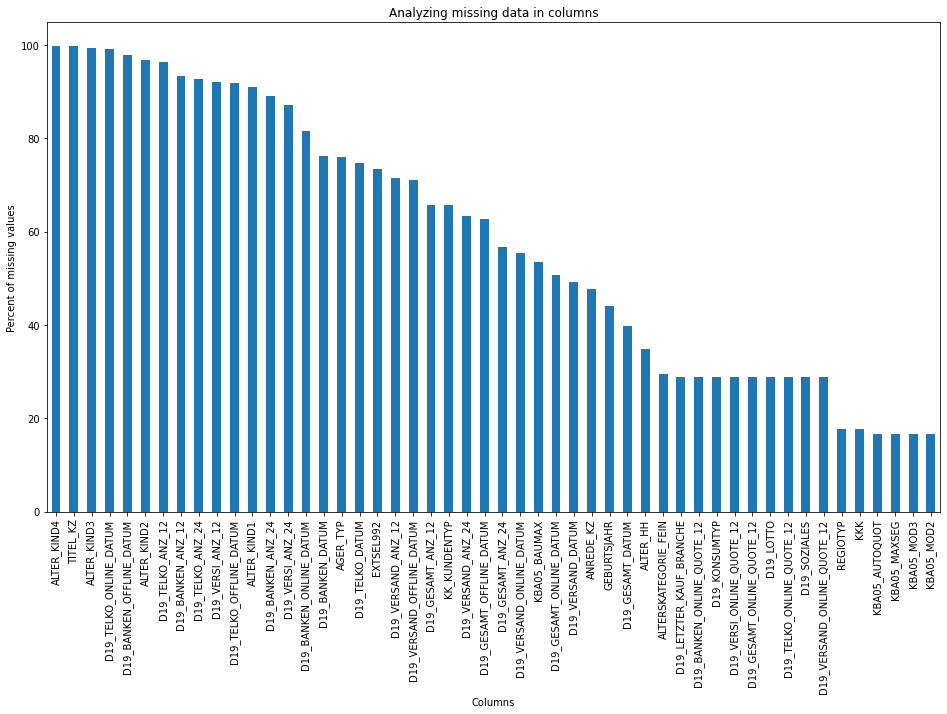

In [53]:
azdias_column_null_percent.sort_values(ascending = False).head(50).plot.bar(figsize = (16, 9))
plt.ylabel('Percent of missing values')
plt.xlabel('Columns')
plt.title('Analyzing missing data in columns')

In [54]:
more_than_20 = len(azdias_column_null_percent[azdias_column_null_percent > 20])
more_than_30 = len(azdias_column_null_percent[azdias_column_null_percent > 30])
more_than_50 = len(azdias_column_null_percent[azdias_column_null_percent > 50])

In [55]:
print("There are {} columns with more than 50% of missing values, {} columns with more than 30%"\
      " of missing values and {} columns with more than 20% of missing values."\
      .format(more_than_50, more_than_30, more_than_20))

There are 29 columns with more than 50% of missing values, 34 columns with more than 30% of missing values and 44 columns with more than 20% of missing values.


In [56]:
columns_to_drop = ['LNR', 'EINGEFUEGT_AM']
columns_to_drop = columns_to_drop + list(azdias_column_null_percent[azdias_column_null_percent > 50].index)
print("We will drop all columns that have more than 50% of missing data: {}".format(columns_to_drop))

We will drop all columns that have more than 50% of missing data: ['LNR', 'EINGEFUEGT_AM', 'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [57]:
print("We will drop {} columns : {}".format(len(columns_to_drop), columns_to_drop))

We will drop 31 columns : ['LNR', 'EINGEFUEGT_AM', 'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


We have decided to drop all column which have more than 50% of missing data.

### Analyzing missing data in rows

We have to perform similar analysis of missing values in rows also.

In [58]:
number_of_nan_per_row = azdias_converted_nan.isnull().sum(axis=1)
number_of_nan_per_row.describe()

count    891221.000000
mean         59.112389
std          78.129974
min           3.000000
25%          21.000000
50%          29.000000
75%          43.000000
max         288.000000
dtype: float64

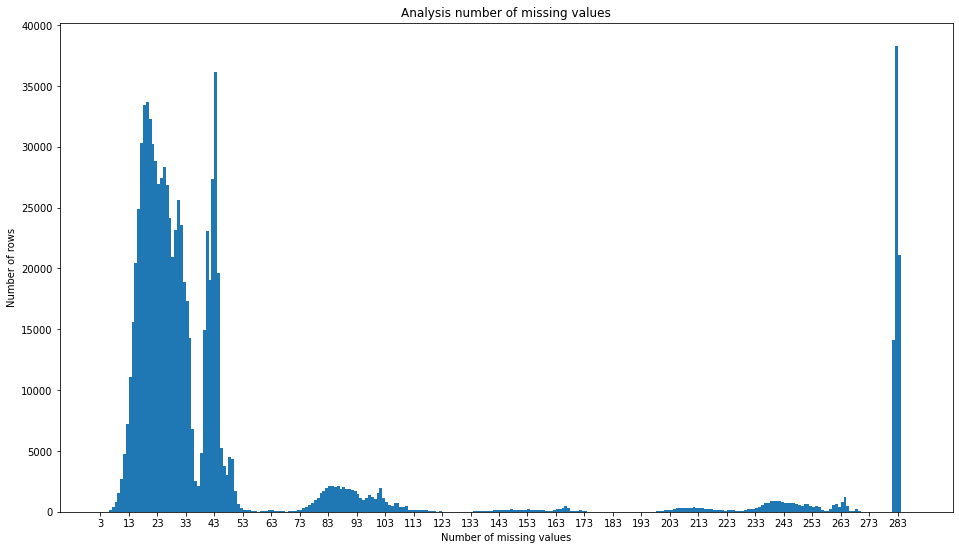

In [59]:
plt.figure(figsize=(16, 9))
n = math.ceil((number_of_nan_per_row.max() - number_of_nan_per_row.min()))
plt.hist(number_of_nan_per_row, bins = n)

plt.xticks(np.arange(min(number_of_nan_per_row), max(number_of_nan_per_row), 10))
plt.ylabel('Number of rows')
plt.xlabel('Number of missing values')
plt.title('Analysis number of missing values');

Also it's worth to have a look at percentage of missing values in rows.

In [60]:
percent_of_nan_per_row = (number_of_nan_per_row / len(azdias_converted_nan.columns)) * 100
percent_of_nan_per_row.describe()

count    891221.000000
mean         16.150926
std          21.346987
min           0.819672
25%           5.737705
50%           7.923497
75%          11.748634
max          78.688525
dtype: float64

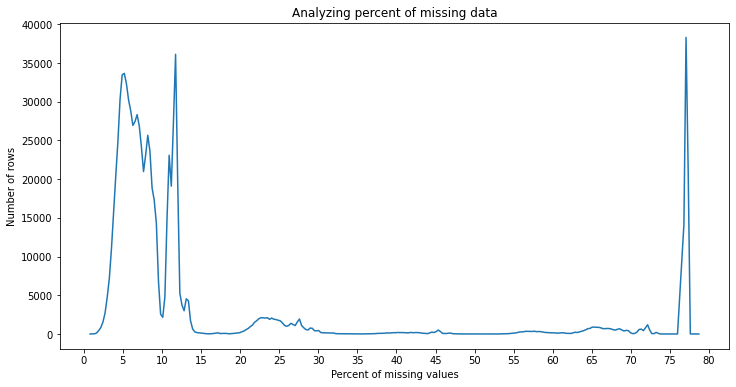

In [61]:
x = percent_of_nan_per_row.value_counts().sort_index(ascending = False)
plt.figure(figsize = (12, 6))
plt.xticks(np.arange(0, 100, 5))
plt.xlabel('Percent of missing values')
plt.ylabel('Number of rows')
plt.title('Analyzing percent of missing data')
plt.plot(x)

We can see that high number of row has a small percentage of missing values (< 30%). And a relatively small number of rows has a high percentage of missing values. We have decided to drop all rows with more than 30% of missing values.

In [62]:
num_of_rows_to_drop = percent_of_nan_per_row[(percent_of_nan_per_row.values > 30)].count()

In [63]:
print("We will drop {} rows which have more than 30% of missing values.".format(num_of_rows_to_drop))

We will drop 107503 rows which have more than 30% of missing values.


In [64]:
rows_to_drop = percent_of_nan_per_row[(percent_of_nan_per_row.values > 30)].index
azdias_reduced = azdias.drop(columns = columns_to_drop, axis = 1)
azdias_reduced = azdias_reduced.drop(rows_to_drop)
azdias_reduced.shape

(783718, 335)

In [65]:
customers_reduced = customers.drop(columns = customers_columns_difference + columns_to_drop, axis = 1)
customers_reduced.shape

(191652, 335)

In [66]:
azdias_reduced.to_pickle('azdias_reducedn.pickle')
customers_reduced.to_pickle('customers_reduced.pickle')
#azdias_reduced = pd.read_pickle('azdias_reduced.pickle')
#customers_reduced = pd.read_pickle('customers_reduced.pickle')

### Feature engineering - imputing missing values

A separate strategy will be used for each type of data when imputing missing values:

- Nominal and binary features missing values will be replaced with the most frequent value of each feature.
- Numerical features missing values will be replaced with the mean value of each feature.

Nominal columns have been identified by analysing two documents describing features.

In [67]:
nominal_columns = ['AGER_TYP', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER',
                   'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 
                   'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'TITEL_KZ']

### Identify categorical columns

In [68]:
azdias_nominal, azdias_binary, azdias_object = prepare_categorical_to_process(azdias_reduced, 
                                                                              columns_to_drop,
                                                                              nominal_columns)

azdias_categorical = azdias_nominal + azdias_binary + azdias_object
azdias_categorical = list(dict.fromkeys(azdias_categorical))
print(azdias_categorical)

['GEBAEUDETYP_RASTER', 'GEBAEUDETYP', 'CAMEO_DEU_2015', 'D19_KONSUMTYP', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'RETOURTYP_BK_S', 'CJT_GESAMTTYP', 'KBA05_MAXHERST', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'HEALTH_TYP', 'OST_WEST_KZ', 'KONSUMZELLE', 'DSL_FLAG', 'UNGLEICHENN_FLAG', 'KBA05_SEG6', 'HH_DELTA_FLAG', 'VERS_TYP', 'SOHO_KZ', 'GREEN_AVANTGARDE', 'D19_LETZTER_KAUF_BRANCHE']


In [69]:
customers_nominal, customers_binary, customers_object = prepare_categorical_to_process(customers_reduced, 
                                                                                      columns_to_drop,
                                                                                      nominal_columns)

customers_categorical = customers_nominal + customers_binary + customers_object
customers_categorical = list(dict.fromkeys(customers_categorical))
print(customers_categorical)

['GEBAEUDETYP_RASTER', 'GEBAEUDETYP', 'CAMEO_DEU_2015', 'D19_KONSUMTYP', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'RETOURTYP_BK_S', 'CJT_GESAMTTYP', 'KBA05_MAXHERST', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'HEALTH_TYP', 'OST_WEST_KZ', 'KONSUMZELLE', 'DSL_FLAG', 'UNGLEICHENN_FLAG', 'KBA05_SEG6', 'HH_DELTA_FLAG', 'VERS_TYP', 'SOHO_KZ', 'GREEN_AVANTGARDE', 'D19_LETZTER_KAUF_BRANCHE']


### Identify numerical columns

In [70]:
azdias_numerical = prepare_numerical_to_process(azdias_reduced, azdias_categorical)
customers_numerical = prepare_numerical_to_process(customers_reduced, customers_categorical)

### Impute missing values and verify the data

In [71]:
impute_missing_values(azdias_reduced, azdias_categorical, azdias_numerical)
azdias_reduced.isnull().values.any()

False

In [72]:
impute_missing_values(customers_reduced, customers_categorical, customers_numerical)
customers_reduced.isnull().values.any()

False

After imputation of data there are no more missing values in any of two datasets.

In [73]:
azdias_reduced.to_pickle('azdias_reduced_nonulls.pickle')
customers_reduced.to_pickle('customers_reduced_nonulls.pickle')

### Skewness

In [74]:
az_skew = azdias_reduced[azdias_numerical].skew(axis = 0)
az_skew.describe()

count    312.000000
mean       0.462310
std        2.121031
min      -16.172385
25%       -0.124203
50%        0.014702
75%        0.357270
max       18.163506
dtype: float64

In [75]:
az_skew[abs(az_skew) > 5]

ANZ_HAUSHALTE_AKTIV            8.773441
ANZ_TITEL                     18.163506
D19_DIGIT_SERV                 5.066238
D19_VERSI_ONLINE_DATUM       -16.172385
ANZ_HH_TITEL                  15.307129
D19_VERSI_OFFLINE_DATUM       -8.602774
ANZ_STATISTISCHE_HAUSHALTE     8.479949
D19_BANKEN_LOKAL               7.440237
dtype: float64

In [76]:
azdias_reduced['D19_VERSI_ONLINE_DATUM'].value_counts()

10    776604
9       2648
8       1211
7       1005
5        952
6        661
4        282
2        132
3        124
1         99
Name: D19_VERSI_ONLINE_DATUM, dtype: int64

In [77]:
azdias_reduced['D19_BANKEN_LOKAL'].value_counts()

0    767934
7      8156
3      3387
6      3042
5      1006
2       114
4        68
1        11
Name: D19_BANKEN_LOKAL, dtype: int64

In [78]:
hidden_missing_data = ['D19_DIGIT_SERV', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 
                       'D19_BANKEN_LOKAL', 'ANZ_TITEL', 'ANZ_HH_TITEL']

In [79]:
azdias_reduced = azdias_reduced.drop(columns = hidden_missing_data, axis = 1)
customers_reduced = customers_reduced.drop(columns = hidden_missing_data, axis = 1)

In [80]:
print(azdias_reduced.shape)
print(customers_reduced.shape)

(783718, 329)
(191652, 329)


In [81]:
azdias_numerical = list(set(azdias_numerical) - set(hidden_missing_data))

In [82]:
report_skewness (azdias_reduced, azdias_numerical, 'Azdias')

The dataset Azdias has min skew of -2.41 and max skew of 8.77.
The dataset Azdias has 77 columns with abs(skew) greater than 0.5.


In [83]:
customers_numerical = list(set(customers_numerical) - set(hidden_missing_data))

In [84]:
report_skewness (customers_reduced, customers_numerical, 'Customers')

The dataset Customers has min skew of -2.69 and max skew of 14.59.
The dataset Customers has 115 columns with abs(skew) greater than 0.5.


### Encoding and scaling

In [85]:
azdias_encoded = pd.get_dummies(azdias_reduced, drop_first = True, columns = azdias_categorical)

In [86]:
azdias_encoded.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
1,9.0,3.0,21.0,11.0,0.0,2.0,12.0,3.0,6.0,8.0,...,0,0,0,0,0,1,0,0,0,0
2,9.0,17.0,17.0,10.0,0.0,1.0,7.0,3.0,2.0,4.0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,13.0,13.0,1.0,0.0,0.0,2.0,2.0,4.0,2.0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,20.0,14.0,3.0,0.0,4.0,3.0,4.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,10.0,10.0,5.0,0.0,1.0,2.0,2.0,6.0,8.0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
customers_encoded = pd.get_dummies(customers_reduced, drop_first = True, columns = customers_categorical)

In [88]:
customers_encoded.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,1.0,10.0,10.0,1.0,0.0,2.0,1.0,1.0,3.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,9.0,11.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,6.0,0.0,1.0,0.0,1.0,1.0,3.0,7.0,5.0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,8.0,8.0,0.0,0.0,0.0,1.0,1.0,7.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,20.0,14.0,7.0,0.0,4.0,7.0,3.0,3.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#list(azdias_encoded.columns.symmetric_difference(cusomers_encoded.columns))
list(customers_encoded.columns.symmetric_difference(azdias_encoded.columns))

['GEBAEUDETYP_5.0']

### Log Transform

In [90]:
azdias_log_transformed = log_transform_skewed_data_frame(azdias_encoded)

In [91]:
customers_log_transformed = log_transform_skewed_data_frame(customers_encoded)

### Standardize and scale the data

In [92]:
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_log_transformed)
customers_scaled = scaler.fit_transform(customers_log_transformed)
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns = azdias_encoded.columns)
customers_scaled_df = pd.DataFrame(customers_scaled, columns = customers_encoded.columns)

In [93]:
azdias_scaled_df.to_pickle('azdias_scaled_df.pickle')
customers_scaled_df.to_pickle('customers_scaled_df.pickle')
#azdias_scaled_df = pd.read_pickle('azdias_scaled_df.pickle')
#customers_scaled_df = pd.read_pickle('customers_scaled_df.pickle')

In [94]:
azdias_scaled_df.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,1.183713,-1.488153,1.021944,0.839492,-0.330091,0.440393,1.022170,-0.027727,0.829075,0.913425,...,-0.241061,-0.093068,-0.134383,-0.119648,-0.056331,1.080259,-0.181743,-0.276466,-0.211166,-0.051673
1,1.183713,0.795244,0.769475,0.744970,-0.330091,-0.613679,0.475323,-0.027727,-0.841754,-0.391245,...,-0.241061,-0.093068,-0.134383,-0.119648,-0.056331,1.080259,-0.181743,-0.276466,-0.211166,-0.051673
2,-0.984153,0.413714,0.453290,-1.106941,-0.330091,-2.415627,-0.629424,-1.079838,0.165568,-1.525090,...,-0.241061,-0.093068,-0.134383,-0.119648,-0.056331,1.080259,-0.181743,-0.276466,-0.211166,-0.051673
3,-0.984153,1.029266,0.540092,-0.353958,-0.330091,1.768368,-0.305396,0.788354,-0.841754,0.355599,...,-0.241061,-0.093068,-0.134383,-0.119648,-0.056331,-0.925704,-0.181743,-0.276466,-0.211166,-0.051673
4,-0.984153,0.047597,0.149878,0.086509,-0.330091,-0.613679,-0.629424,-1.079838,0.829075,0.913425,...,-0.241061,-0.093068,-0.134383,-0.119648,-0.056331,-0.925704,-0.181743,-0.276466,-0.211166,-0.051673


In [95]:
customers_scaled_df.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,-0.354525,0.490480,0.590889,-0.531376,-0.651088,0.246443,-0.522401,-1.218439,0.085130,-1.133726,...,-0.286522,-0.098349,-0.106038,-0.110285,-0.042466,1.186371,-0.138732,-0.241166,-0.217371,-0.08652
1,3.765911,0.581375,-1.248577,-0.531376,-0.651088,0.935701,-0.522401,-1.218439,-1.141667,-1.133726,...,-0.286522,-0.098349,-0.106038,-0.110285,-0.042466,-0.842906,-0.138732,-0.241166,-0.217371,-0.08652
2,-0.354525,0.018317,-1.996501,-0.531376,-0.651088,-0.725013,-0.522401,0.665905,1.311928,0.802246,...,-0.286522,-0.098349,-0.106038,-0.110285,-0.042466,1.186371,-0.138732,-0.241166,-0.217371,-0.08652
3,-0.354525,0.280851,0.374360,-1.458244,-0.651088,-2.385726,-0.522401,-1.218439,1.311928,0.480959,...,-0.286522,-0.098349,-0.106038,-0.110285,-0.042466,-0.842906,-0.138732,-0.241166,-0.217371,-0.08652
4,-0.354525,1.165973,0.925554,1.322362,-0.651088,1.470331,1.401933,0.665905,0.085130,1.309199,...,-0.286522,-0.098349,-0.106038,-0.110285,-0.042466,-0.842906,-0.138732,-0.241166,-0.217371,-0.08652


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality reduction

In [96]:
from sklearn.decomposition import PCA

In [97]:
pca = PCA().fit(azdias_scaled_df)

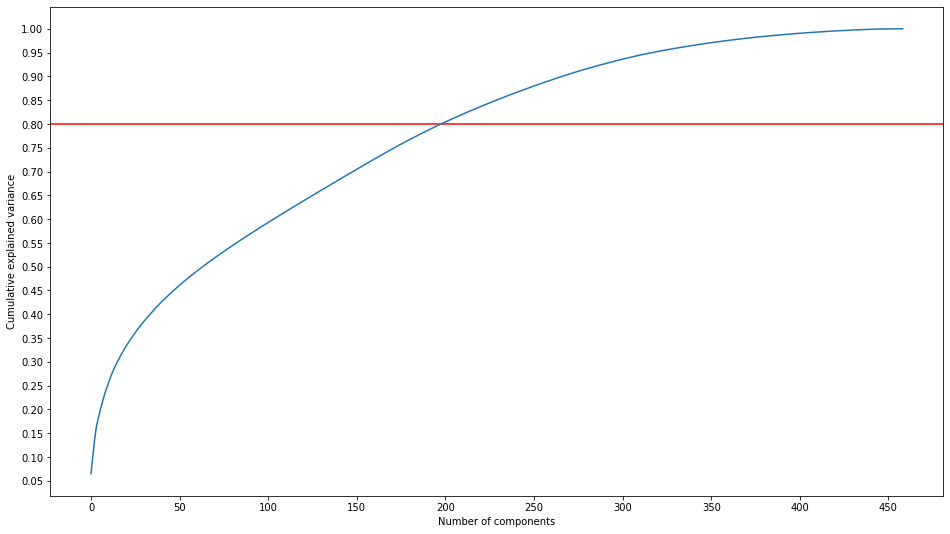

In [98]:
plt.figure(figsize = (16, 9))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.yticks(np.arange(0, 1.1, 0.05))
plt.xticks(np.arange(0, 500, 50))
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [99]:
azdias_pca = PCA(n_components = .8).fit(azdias_scaled_df)

In [100]:
azdias_pca_df = pd.DataFrame(azdias_pca.transform(azdias_scaled_df))
azdias_pca_df = azdias_pca_df.add_prefix('PC')
azdias_pca_df.shape

(783718, 199)

In [101]:
azdias_pca_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198
0,5.180082,4.175165,5.725139,-4.253344,0.064605,-2.030514,4.284673,-2.482100,-1.898158,1.337125,...,-2.293966,-0.666230,0.490447,0.479715,-0.413531,-0.448929,1.354440,-1.143302,0.334694,0.672738
1,-0.567736,2.391576,1.149684,-2.072202,4.005686,-4.095514,-4.767354,-2.180499,1.197083,-0.874037,...,0.608807,0.298037,-1.326184,-0.716530,0.078567,-0.198850,-0.273019,0.355905,-0.916766,0.293698
2,-5.471735,1.021422,-3.189485,-3.626945,-0.556297,-1.403706,1.606815,-0.188823,1.196153,-0.627186,...,-0.612579,1.130500,0.752524,-0.736349,0.499662,-0.332580,-0.949248,0.373634,-0.767270,-0.015723
3,-1.765155,1.590001,2.696561,5.170921,-2.404794,2.467033,-2.375770,0.062268,1.366010,-1.501177,...,0.232603,1.079244,-0.676011,-0.894092,0.339374,1.134731,-0.873142,0.540408,0.906200,0.663386
4,-2.694314,1.909560,-1.043844,-2.752621,1.098809,-0.118922,0.746305,-3.317361,0.110090,-2.148852,...,-0.702530,0.138523,0.266960,-0.555426,0.491346,-0.132139,0.859366,0.172717,0.184987,0.621299


In [102]:
top_10 = azdias_pca.explained_variance_ratio_[:10]

In [103]:
top_10.sum()

0.2468398422559505

In [105]:
for n in np.arange(10, 210, 10):
    print('{} components explains {} % of variance.'.format(n, round(azdias_pca.explained_variance_ratio_[:n].sum()*100)))

10 components explains 25 % of variance.
20 components explains 33 % of variance.
30 components explains 38 % of variance.
40 components explains 42 % of variance.
50 components explains 46 % of variance.
60 components explains 49 % of variance.
70 components explains 52 % of variance.
80 components explains 54 % of variance.
90 components explains 57 % of variance.
100 components explains 59 % of variance.
110 components explains 61 % of variance.
120 components explains 64 % of variance.
130 components explains 66 % of variance.
140 components explains 68 % of variance.
150 components explains 70 % of variance.
160 components explains 72 % of variance.
170 components explains 75 % of variance.
180 components explains 77 % of variance.
190 components explains 78 % of variance.
200 components explains 80 % of variance.


### Interpreting principal components

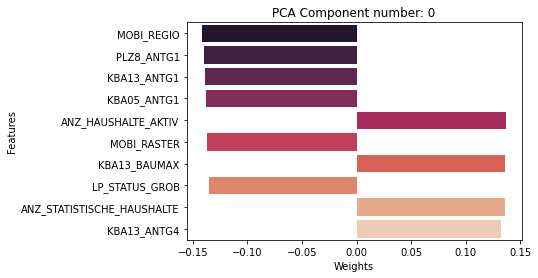

      Weights                    Features  abs_weights
261 -0.141702                  MOBI_REGIO     0.141702
264 -0.139756                  PLZ8_ANTG1     0.139756
140 -0.138562                 KBA13_ANTG1     0.138562
79  -0.138167                 KBA05_ANTG1     0.138167
3    0.137178         ANZ_HAUSHALTE_AKTIV     0.137178
260 -0.136995                 MOBI_RASTER     0.136995
147  0.135768                KBA13_BAUMAX     0.135768
258 -0.135587              LP_STATUS_GROB     0.135587
6    0.135585  ANZ_STATISTISCHE_HAUSHALTE     0.135585
143  0.132346                 KBA13_ANTG4     0.132346


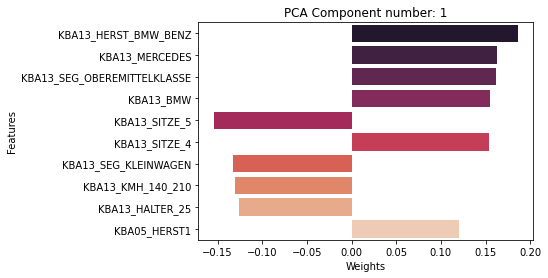

      Weights                     Features  abs_weights
186  0.186283         KBA13_HERST_BMW_BENZ     0.186283
221  0.162965               KBA13_MERCEDES     0.162965
235  0.161508  KBA13_SEG_OBEREMITTELKLASSE     0.161508
154  0.155055                    KBA13_BMW     0.155055
243 -0.154574                KBA13_SITZE_5     0.154574
242  0.154284                KBA13_SITZE_4     0.154284
230 -0.133110         KBA13_SEG_KLEINWAGEN     0.133110
194 -0.130648            KBA13_KMH_140_210     0.130648
174 -0.125622              KBA13_HALTER_25     0.125622
91   0.120393                 KBA05_HERST1     0.120393


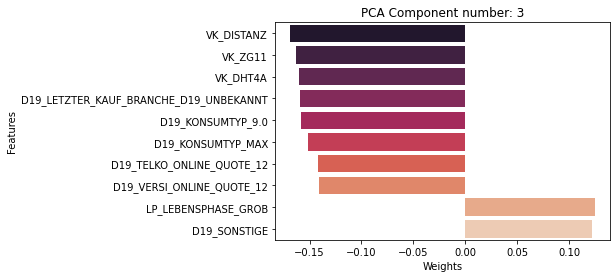

      Weights                                Features  abs_weights
298 -0.168647                              VK_DISTANZ     0.168647
299 -0.162590                                 VK_ZG11     0.162590
297 -0.159894                                VK_DHT4A     0.159894
454 -0.158976  D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT     0.158976
364 -0.158011                       D19_KONSUMTYP_9.0     0.158011
36  -0.151070                       D19_KONSUMTYP_MAX     0.151070
49  -0.142279               D19_TELKO_ONLINE_QUOTE_12     0.142279
56  -0.140681               D19_VERSI_ONLINE_QUOTE_12     0.140681
257  0.124361                     LP_LEBENSPHASE_GROB     0.124361
45   0.121776                            D19_SONSTIGE     0.121776


In [106]:
pca_list = [0, 1, 3]
  
for i in pca_list:
    result_data = plot_component_weights_and_features(i, azdias_pca, azdias_encoded)
    print(result_data)

### Finding the optimal number of clusters

In [107]:
num_of_clusters = range(1, 31)
sum_of_squared_distances = []

for i in num_of_clusters:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_jobs = -1)
    kmeans.fit(azdias_pca_df.sample(30000))
    sum_of_squared_distances.append(kmeans.inertia_)

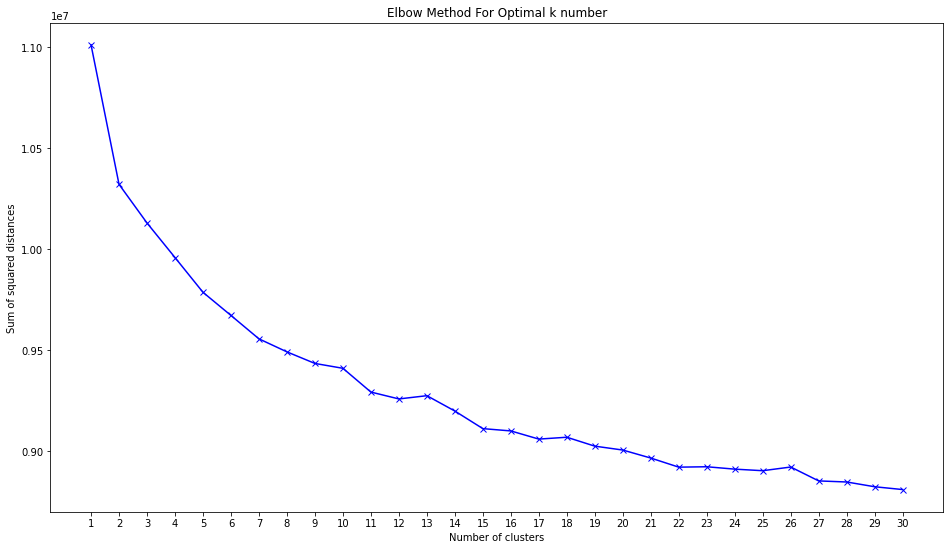

In [108]:
plt.figure(figsize=(16, 9))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k number')
plt.xticks(list(range(1, 31)))
plt.plot(num_of_clusters, sum_of_squared_distances, 'bx-')

### Calculating population clusters

In [109]:
azdias_km = KMeans(n_clusters = 10, init = 'k-means++', n_jobs = -1).fit(azdias_pca_df)
azdias_clusters = azdias_km.predict(azdias_pca_df)
azdias_clusters_df = pd.DataFrame(azdias_clusters, columns = ['Cluster Number'])
azdias_clusters_df['Cluster Number'].unique()

array([6, 7, 2, 1, 0, 9, 5, 3, 4, 8], dtype=int32)

In [110]:
azdias_clusters_df.to_pickle('azdias_clusters_df')
#azdias_clusters_df = pd.read_pickle('azdias_clusters_df')

### Plotting the population clusters

<AxesSubplot:title={'center':'Population clusters'}>

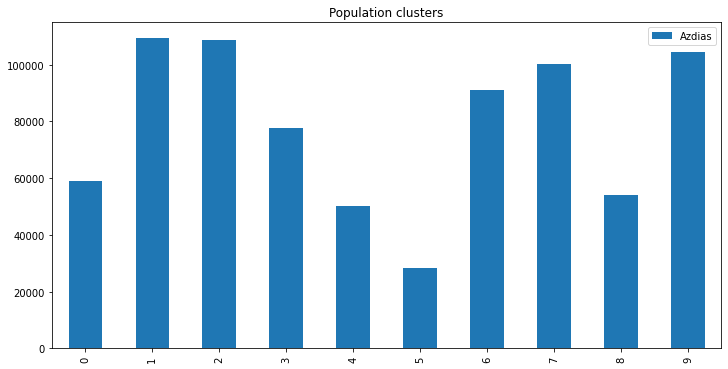

In [271]:
azdias_cs = pd.Series(azdias_clusters, name = 'Azdias')
azdias_cs_counts = azdias_cs.value_counts().sort_index()
azdias_cs_df = pd.DataFrame(azdias_cs_counts)
azdias_cs_df.plot(figsize = (12, 6), kind = 'bar', title = 'Population clusters')

Most of the clusters in this data set are of the similar scale.

### Calculating customers clusters

In [112]:
customers_pca = PCA(n_components = .8).fit(customers_scaled_df)
customers_pca_df = pd.DataFrame(customers_pca.transform(customers_scaled_df))
customers_pca_df = customers_pca_df.add_prefix('PC')

In [113]:
customers_km = KMeans(n_clusters = 10, init = 'k-means++', n_jobs = -1).fit(customers_pca_df)

In [114]:
customers_clusters = customers_km.predict(customers_pca_df)
customers_clusters_df = pd.DataFrame(customers_clusters, columns = ['Cluster Number'])

In [115]:
customers_clusters_df.to_pickle('customers_clusters_df')
#customers_clusters_df = pd.read_pickle('customers_clusters_df')

### Plotting customers clusters

<AxesSubplot:title={'center':'Customers clusters'}>

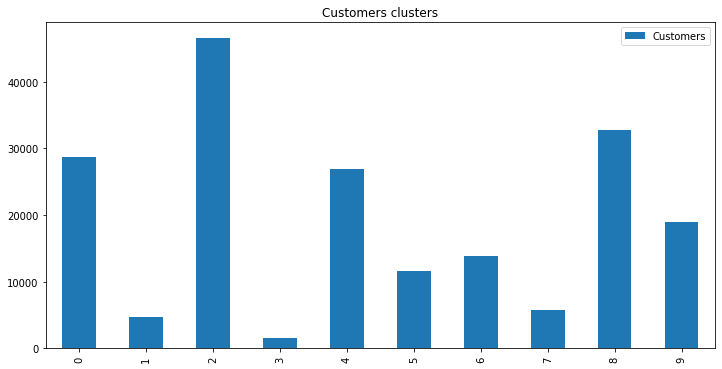

In [272]:
customers_cs = pd.Series(customers_clusters, name = 'Customers')
customers_cs_counts = customers_cs.value_counts().sort_index()
customers_cs_df = pd.DataFrame(customers_cs_counts)
customers_cs_df.plot(figsize = (12, 6), kind = 'bar', title = 'Customers clusters')

Ther are much bigger differences among clusters in the "customer" data set,

### Joining customers and population clusters

In [137]:
clusters_df = pd.concat([azdias_cs_df, customers_cs_df], axis = 1)
clusters_df.head()

,Azdias,Customers
0,58976,28738
1,109507,4681
2,108884,46601
3,77535,1636
4,50311,26921


In [153]:
clusters_df['Azdias share'] = round(clusters_df.Azdias / clusters_df.Azdias.sum() * 100, 2)
clusters_df['Customers share'] = round(clusters_df.Customers / clusters_df.Customers.sum() * 100, 2)
clusters_df['Ratio'] = round(clusters_df['Customers share'] / clusters_df['Azdias share'], 2)
clusters_df.head(10)

,Azdias,Customers,Azdias share,Customers share,Ratio
0,58976,28738,7.53,14.99,1.99
1,109507,4681,13.97,2.44,0.17
2,108884,46601,13.89,24.32,1.75
3,77535,1636,9.89,0.85,0.09
4,50311,26921,6.42,14.05,2.19
5,28481,11671,3.63,6.09,1.68
6,90968,13878,11.61,7.24,0.62
7,100433,5747,12.81,3.00,0.23
8,54139,32767,6.91,17.10,2.47
9,104484,19012,13.33,9.92,0.74


For both datasets we want to mesure the percentage of the total size in each cluster. We also want to see the ration between "customers" and "population" for those percentages. That ratio will tell us where the most of future prospects are, in which cluster. 

<AxesSubplot:title={'center':'Cluster share'}>

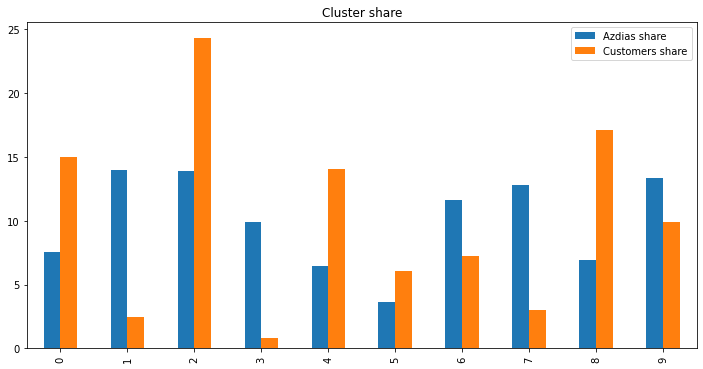

In [273]:
clusters_df[['Azdias share', 'Customers share']].plot(kind = 'bar', figsize=(12, 6), title = "Cluster share")

<AxesSubplot:>

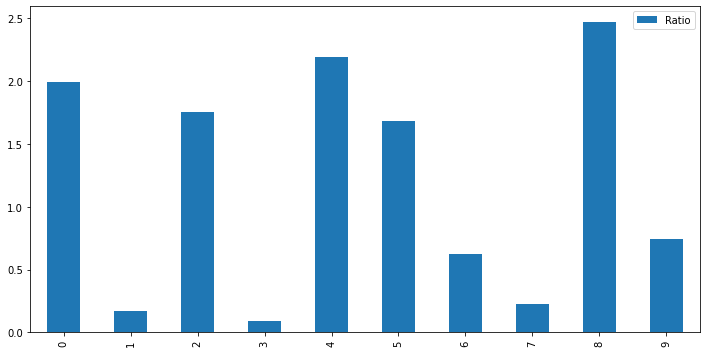

In [156]:
clusters_df[['Ratio']].plot(kind = 'bar', figsize=(12, 6))

We can see that biggest potential of new customers lies in clusters 8, 4, 0 and 2.

### Plotting feature weights for most important clusters

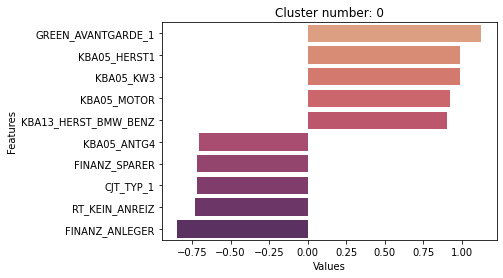

,Features,Descriptions
423,GREEN_AVANTGARDE_1,Description missing
91,KBA05_HERST1,"share of top German manufacturer (Mercedes, BMW)"
107,KBA05_KW3,share of cars with an engine power of more tha...
118,KBA05_MOTOR,most common engine size in the microcell
186,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8
82,KBA05_ANTG4,number of >10 family houses in the cell
65,FINANZ_SPARER,financial typology: money saver
12,CJT_TYP_1,Description missing
274,RT_KEIN_ANREIZ,Description missing
62,FINANZ_ANLEGER,financial typology: investor


In [229]:
customers_cluster_0 = plot_cluster_details(0, customers_pca, customers_km, customers_scaled_df, attribute_values)
customers_cluster_0[['Features', 'Descriptions']].head(10)

The most important features of the cluster no.0 are:
- GREEN_AVANTGARDE_1: belongs to the green avantgarde
- KBA05_HERST1: share of top German manufacturer (Mercedes, BMW)
- KBA05_KW3: share of cars with and engine power more than 119 KW
- FINANZ_ANLEGER: financial topology - investor

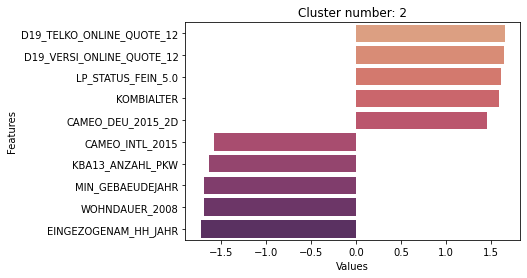

,Features,Descriptions
49,D19_TELKO_ONLINE_QUOTE_12,Description missing
56,D19_VERSI_ONLINE_QUOTE_12,Description missing
405,LP_STATUS_FEIN_5.0,Description missing
253,KOMBIALTER,Description missing
322,CAMEO_DEU_2015_2D,Description missing
10,CAMEO_INTL_2015,Description missing
144,KBA13_ANZAHL_PKW,number of cars in the PLZ8
259,MIN_GEBAEUDEJAHR,year the building was first mentioned in our d...
301,WOHNDAUER_2008,length of residence
60,EINGEZOGENAM_HH_JAHR,Description missing


In [230]:
customers_cluster_2 = plot_cluster_details(2, customers_pca, customers_km, customers_scaled_df, attribute_values)
customers_cluster_2[['Features', 'Descriptions']].head(10)

The most important features of the cluster no.2 are:
- D19_TELKO_ONLINE_QUOTE_12
- D19_VERSI_ONLINE_QUOTE_12
- EINGEZOGENAM_HH_JAHR
- WOHNDAUER_2008: length of residence

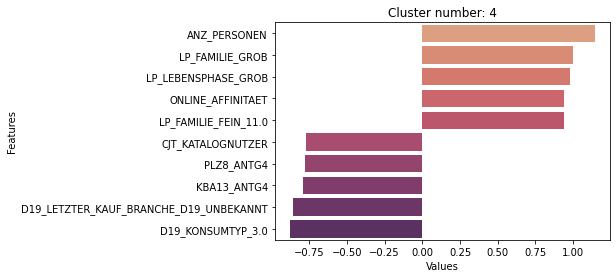

,Features,Descriptions
5,ANZ_PERSONEN,number of adult persons in the household
255,LP_FAMILIE_GROB,familytyp rough
257,LP_LEBENSPHASE_GROB,lifestage rough
262,ONLINE_AFFINITAET,online affinity
374,LP_FAMILIE_FEIN_11.0,Description missing
11,CJT_KATALOGNUTZER,Description missing
267,PLZ8_ANTG4,number of >10 family houses in the PLZ8
143,KBA13_ANTG4,Description missing
453,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,Description missing
359,D19_KONSUMTYP_3.0,Description missing


In [231]:
customers_cluster_4 = plot_cluster_details(4, customers_pca, customers_km, customers_scaled_df, attribute_values)
customers_cluster_4[['Features', 'Descriptions']].head(10)

The most important features of the cluster no.4 are:
- ANZ_PERSONEN: number of adult persons in the household
- LP_FAMILIE_GROB: family type
- LP_LEBENSPHASE_GROB: life style
- ONLINE_AFFINITAET: online affinity

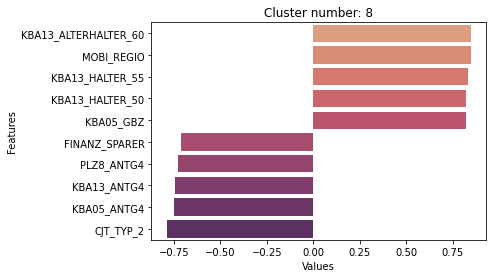

,Features,Descriptions
138,KBA13_ALTERHALTER_60,share of car owners between 46 and 60 within t...
261,MOBI_REGIO,moving patterns
180,KBA13_HALTER_55,share of car owners between 51 and 55 within t...
179,KBA13_HALTER_50,share of car owners between 46 and 50 within t...
90,KBA05_GBZ,number of buildings in the microcell
65,FINANZ_SPARER,financial typology: money saver
267,PLZ8_ANTG4,number of >10 family houses in the PLZ8
143,KBA13_ANTG4,Description missing
82,KBA05_ANTG4,number of >10 family houses in the cell
13,CJT_TYP_2,Description missing


In [232]:
customers_cluster_8 = plot_cluster_details(8, customers_pca, customers_km, customers_scaled_df, attribute_values)
customers_cluster_8[['Features', 'Descriptions']].head(10)

The most important features of the cluster no.8 are:
- KBA13_ALTERHALTER_60: share of car owners between 46 and 60 within the PLZ8
- MOBI_REGIO: moving patterns
- KBA13_HALTER_55: share of car owners between 51 and 55 within the PLZ8
- KBA13_HALTER_50: share of car owners between 46 and 50 within the PLZ8

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### The list of nominal columns

In [159]:
mail_nominal = ['AGER_TYP', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER',
                'GFK_URLAUBERTYP', 'HEALTH_TYP', 'KBA05_MAXHERST', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 
                'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'TITEL_KZ']

In [160]:
mail_to_drop = columns_to_drop

### The list of columns with a lot of missing data

In [161]:
mail_hidden = ['D19_DIGIT_SERV', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_BANKEN_LOKAL', 
               'ANZ_TITEL', 'ANZ_HH_TITEL']

In [162]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/vajolukic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [163]:
mailout_train.shape

(42962, 367)

In [164]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [165]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

### Plot the distribution of the "response" variable

<AxesSubplot:>

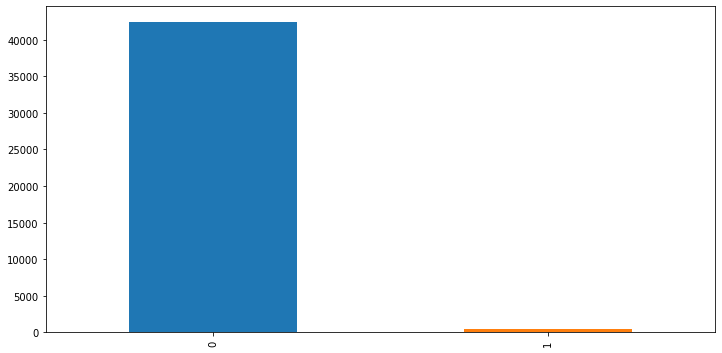

In [166]:
mailout_train['RESPONSE'].value_counts().plot(kind = 'bar', figsize=(12, 6), color=['C0', 'C1'])

### Cleaning "mailout" data set

In [168]:
mailout_train_reduced = clean_mailout_data(mailout_train, unknown_values_dict, columns_to_drop, hidden_missing_data)
mailout_train_reduced.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,8.0,8.0,15.0,0.0,1.0,13.0,3.0,5.0,5D,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,1.0,4
1,4.0,13.0,13.0,1.0,0.0,2.0,1.0,2.0,5.0,5B,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,1.0,3
2,1.0,9.0,7.0,0.0,0.0,0.0,1.0,4.0,1.0,2D,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,NaN,4
3,1.0,6.0,6.0,4.0,0.0,2.0,4.0,4.0,2.0,2D,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,1.0,4
4,1.0,9.0,9.0,53.0,0.0,1.0,44.0,3.0,4.0,7B,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,NaN,3


In [169]:
mailout_train_reduced.shape

(42962, 330)

In [170]:
response_df = pd.DataFrame(mailout_train_reduced['RESPONSE'].values, columns = ['RESPONSE'])
mailout_train_features = mailout_train_reduced.drop(['RESPONSE'], axis = 1)    

In [172]:
mailout_train_imputed, categorical_columns = impute_mailout_data(mailout_train_features, 
                                                                 columns_to_drop, 
                                                                 mail_nominal)

In [173]:
mailout_train_imputed.isnull().values.any()

False

In [174]:
response_df['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

### Encode and scale the "mailout" data set

In [176]:
mailout_train_scaled_df = encode_and_scale_mailout_data(mailout_train_imputed, categorical_columns)
mailout_train_scaled_df.shape

(42962, 458)

In [177]:
mailout_train_scaled_df.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,-0.294146,0.243780,0.306852,1.643132,-0.507373,-0.610154,1.579700,0.408840,0.708125,0.502711,...,-0.261662,-0.094717,-0.113246,-0.112718,-0.052032,1.185532,-0.138797,-0.257011,-0.23723,-0.085392
1,2.299651,0.737730,0.789100,-0.705536,-0.507373,0.334210,-0.705277,-0.373297,0.708125,0.502711,...,-0.261662,-0.094717,8.830304,-0.112718,-0.052032,-0.843503,-0.138797,-0.257011,-0.23723,-0.085392
2,-0.294146,0.361569,0.178295,-1.488425,-0.507373,-2.224555,-0.705277,1.015513,-1.235171,-0.716065,...,-0.261662,-0.094717,-0.113246,-0.112718,-0.052032,-0.843503,-0.138797,-0.257011,-0.23723,-0.085392
3,-0.294146,-0.037178,0.032549,0.329388,-0.507373,0.334210,0.370673,1.015513,-0.517958,-0.716065,...,-0.261662,-0.094717,-0.113246,-0.112718,-0.052032,1.185532,-0.138797,-0.257011,-0.23723,-0.085392
4,-0.294146,0.361569,0.421850,3.017015,-0.507373,-0.610154,2.950755,0.408840,0.385623,1.008548,...,-0.261662,-0.094717,-0.113246,-0.112718,-0.052032,-0.843503,-0.138797,-0.257011,-0.23723,-0.085392


In [178]:
mailout_train_scaled_df.isnull().values.any()

False

### Create train and validation data sets

In [180]:
train_y = response_df
train_x = mailout_train_scaled_df

In [182]:
X_train, X_validation, y_train, y_validation = train_test_split(train_x, train_y, test_size = 0.2, random_state = 37)

### Train logistic regression model as a benchmark

In [185]:
lr = LogisticRegression(random_state = 37)
lr.fit(X_train, y_train.values.ravel())

/Users/vajolukic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=37, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
y_pred = lr.predict_proba(X_validation)[:,1]

In [187]:
print('Accuracy on validation set: {:.2f}'.format(lr.score(X_validation, y_validation)))
print('Logistic regression ROC-AUC: {:.2f}'.format(roc_auc_score(y_validation, y_pred)))

Accuracy on validation set: 0.99
Logistic regression ROC-AUC: 0.61


### Try various classification models

In [188]:
warnings.filterwarnings("ignore")

n_jobs = -1
models = [
    ('LR', LogisticRegression(n_jobs = -1)), 
    ('XGB', XGBClassifier(nthread = -1)),
    ('GNB', GaussianNB()),
    ('KNN', KNeighborsClassifier(n_neighbors=5,n_jobs = -1)),
    ('AB', AdaBoostClassifier()),  
    ('RF', RandomForestClassifier(n_jobs = -1)),
    ("GRB", GradientBoostingClassifier())
]

results = []
names = []

In [189]:
for name, model in models:
    model = model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict_proba(X_validation)[:,1]
    roc_score = roc_auc_score(y_validation, y_pred)

    results.append(roc_score)
    names.append(name)

result_df = pd.DataFrame(list(zip(names, results)), columns = ['Model', 'Score'])

[12:51:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [190]:
result_df

,Model,Score
0,LR,0.611429
1,XGB,0.639996
2,GNB,0.509893
3,KNN,0.516694
4,AB,0.727124
5,RF,0.571227
6,GRB,0.753262


It seams that the "Gradient boosting" model has the best score. We will tune hyper parameters of that mdoel further.

### Hyperparameter tuning

In [195]:
parameters = {
    "learning_rate": [0.05, 0.1, 0.5, 1],
    "max_depth": [3, 5, 7, 9],
    "n_estimators": [50, 100, 150, 200],
    "max_features": [25, 50, 75, 100]
    }
        
clf = GridSearchCV(GradientBoostingClassifier(), 
                   parameters, 
                   scoring = 'roc_auc', 
                   n_jobs = -1,
                   cv = 5,
                   verbose = 10)

In [196]:
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [203]:
best_estimator = clf.best_estimator_
print("Best estimator on validation data: {}".format(best_estimator))

Best estimator on validation data: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=100, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [204]:
best_estimator_result = best_estimator.predict_proba(X_validation)[:,1]
print("ROC score on validation data: {:.2f}".format(roc_auc_score(y_validation, best_estimator_result)))

ROC score on validation data: 0.76


<AxesSubplot:>

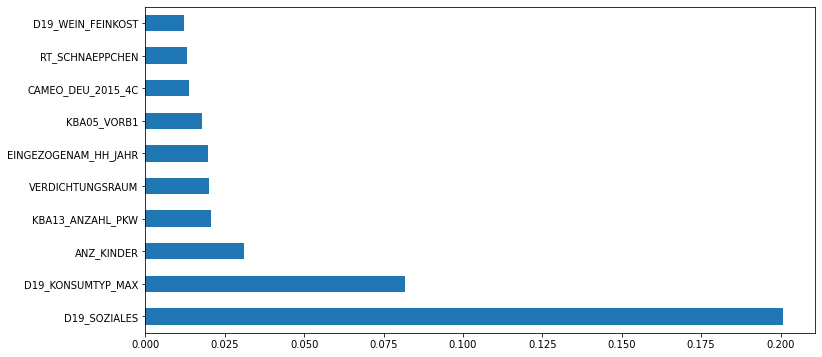

In [205]:
feature_importances = pd.Series(best_estimator.feature_importances_, index = X_train.columns)
feature_importances.nlargest(10).plot(kind = 'barh', figsize = (12, 6))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### Loading test data set

Let's load the test data set...

In [233]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

### Observing the data set

We have to look at the data in this data set and find out if there are any missing values for example.

In [234]:
mailout_test.shape

(42833, 366)

In [235]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


Aparently, there are missing values. For that reason we will perform the same data cleaning steps. asin previous cases.

### Cleaning the test data set

In [236]:
mailout_test_reduced = clean_mailout_data(mailout_test, unknown_values_dict, columns_to_drop, hidden_missing_data)
mailout_test_reduced.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,7.0,6.0,2.0,0.0,2.0,2.0,3.0,6.0,2B,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,NaN,4
1,1.0,NaN,0.0,20.0,0.0,1.0,21.0,4.0,7.0,5A,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,NaN,4
2,9.0,16.0,11.0,2.0,0.0,4.0,2.0,4.0,1.0,7A,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,1.0,4
3,7.0,NaN,0.0,1.0,0.0,0.0,1.0,4.0,1.0,2B,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,1.0,4
4,1.0,21.0,13.0,1.0,0.0,4.0,1.0,3.0,6.0,5A,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,1.0,4


### Imputing missing values into the test data set

In [237]:
mailout_test_imputed, categorical_test_columns = impute_mailout_data(mailout_test_reduced, 
                                                                     columns_to_drop, 
                                                                     mail_nominal)

In [238]:
mailout_test_imputed.isnull().values.any()

False

After imputing some data there are no more missing values in the test data set.

### Scaling the test data set

In [239]:
mailout_test_scaled_df = encode_and_scale_mailout_data(mailout_test_imputed, categorical_test_columns)
mailout_test_scaled_df.shape

(42833, 458)

### Making predictions for the test data set

In [240]:
mailout_test_lnr = mailout_test['LNR']

In [242]:
kaggle_grb = best_estimator.predict_proba(mailout_test_scaled_df)[:,1]

In [243]:
kaggle_grb_df = pd.DataFrame(data = kaggle_grb, index = mailout_test_lnr, columns = ['RESPONSE'])

In [244]:
kaggle_grb_df.head()

,RESPONSE
LNR,
1754,0.031588
1770,0.040468
1465,0.002991
1470,0.005107
1478,0.004093


### Saving predictions to a file

In [245]:
kaggle_grb_df.to_csv("data/submission2.csv")

After making a submission to the Kaggle competition, the score of 0.78583 has been achieved with the 224th place on the score board.